In [25]:
import numpy as np
from dataclasses import dataclass
import random
'''
To Do

- add lactate fermentation
- refine glucose metabolism pathway, add "burning"
- have insulin and glucagon modulate metabolism of glucose, FA, and AA
- refine oxidative phosphorylation pathway

- Ectopic fat storage
- inflammation management
- have protein intake as well as growth hormones modulate muscle mass (volume)
- add clearances


'''

n=17

@dataclass
class Parameters:
    insulin_blood_skeletalmuscle: float
    insulin_skeletalmuscle_blood: float

    V_skeletalmuscle: float

    glucagon_blood_skeletalmuscle: float
    glucagon_skeletalmuscle_blood: float

    fattyacids_blood_skeletalmuscle: float
    fattyacids_skeletalmuscle_blood: float

    glucose_blood_skeletalmuscle: float
    glucose_skeletalmuscle_blood: float

    aminoacids_blood_skeletalmuscle: float
    aminoacids_skeletalmuscle_blood: float

    lactate_blood_skeletalmuscle: float
    lactate_skeletalmuscle_blood: float

    growthhormone_blood_skeletalmuscle: float
    growthhormone_skeletalmuscle_blood: float

    V_blood: float

    isExercising: bool

    glucose_to_g6p: float
    g6p_to_glucose: float

    g6p_to_glycogen: float
    glycogen_to_g6p: float

   
    g6p_to_pyruvate: float 
    pyruvate_to_g6p: float


    pyruvate_to_acetylcoa: float 
    acetylcoa_to_TCA: float  

    NADH_ETC: float  
    FADH2_ETC: float  

    fattyacids_to_acetylcoa: float  
    aminoacids_to_acetylcoa: float 
    pyruvate_to_lactate: float
    lactate_to_pyruvate: float
    isOxygenated: float #0 or 1


    

p = Parameters(
    insulin_blood_skeletalmuscle=0.1,         
    insulin_skeletalmuscle_blood=0.01,            
    V_skeletalmuscle=25.0,                       
    glucagon_blood_skeletalmuscle=0.1,
    glucagon_skeletalmuscle_blood=0.01,
    
    fattyacids_blood_skeletalmuscle=0.1,         # moderate uptake
    fattyacids_skeletalmuscle_blood=0.01,         # low release

    glucose_blood_skeletalmuscle=10,            # high glucose uptake
    glucose_skeletalmuscle_blood=0.5,            # small reverse flow

    aminoacids_blood_skeletalmuscle=1,
    aminoacids_skeletalmuscle_blood=0.1,

    lactate_blood_skeletalmuscle=0.01,
    lactate_skeletalmuscle_blood=1,

    growthhormone_blood_skeletalmuscle=0.1,
    growthhormone_skeletalmuscle_blood=0.01,

    V_blood=5.0,                                 # blood volume (arbitrary units)

    isExercising=False,

    # Glucose metabolism
    glucose_to_g6p=1,
    g6p_to_glucose=0.1,

    # Glycogen dynamics
    g6p_to_glycogen=1,
    glycogen_to_g6p=0.6,

    # Glycolysis and gluconeogenesis
    g6p_to_pyruvate=1,
    pyruvate_to_g6p=0.1,

    # Acetyl-CoA & TCA
    pyruvate_to_acetylcoa=1,
    acetylcoa_to_TCA=10,

    # ETC
    NADH_ETC=1,
    FADH2_ETC=1,

    # Alternative fuels
    fattyacids_to_acetylcoa=0.01,
    aminoacids_to_acetylcoa=0.1,

    # Anaerobic respiration
    pyruvate_to_lactate=0.1,
    lactate_to_pyruvate=0.01,
    isOxygenated = 1

)

def skeletalmuscle(t, y, p):
    dydt = np.zeros(n)
    
    dinsulin = insulin(t, y, p)
    dglucagon = glucagon(t, y, p)
    dfattyacids = fattyacids(t, y, p)
    dglucose = glucose(t, y, p)
    daminoacids = aminoacids(t, y, p)
    dlactate = lactate(t, y, p)
    dgrowthhormone = growthhormone(t, y, p)
    dg6p = g6p(t,y,p)
    dglycogen = glycogen(t,y,p)
    dpyruvate = pyruvate(t,y,p)
    dacetylcoa = acetylcoa(t,y,p)
    dNAD = NAD(t,y,p)
    dNADH = NADH(t,y,p)
    dFAD = FAD(t,y,p)
    dFADH2 = FADH2(t,y,p)
    dROS = ROS(t,y,p)
    dATP = ATP(t,y,p)
    
    dydt = dinsulin + dglucagon + dfattyacids + dglucose + daminoacids + dlactate + dgrowthhormone + dg6p + dglycogen + dpyruvate + dacetylcoa + dNAD + dNADH + dFAD + dFADH2 + dROS + dATP
    return dydt

def insulin(t, y, p):
    dydt = np.zeros(n)
    dydt[0] = (p.insulin_blood_skeletalmuscle * y[0] *p.V_blood - p.insulin_skeletalmuscle_blood * y[0] * p.V_skeletalmuscle) / p.V_skeletalmuscle
    return dydt

def glucagon(t, y, p):
    dydt = np.zeros(n)
    dydt[1] = (p.glucagon_blood_skeletalmuscle * y[1] * p.V_blood - p.glucagon_skeletalmuscle_blood * y[1] * p.V_skeletalmuscle) / p.V_skeletalmuscle
    return dydt

def fattyacids(t, y, p):
    dydt = np.zeros(n)
    dydt[2] = ((p.fattyacids_blood_skeletalmuscle * y[2] * p.V_blood - p.fattyacids_skeletalmuscle_blood * y[2] * p.V_skeletalmuscle) / p.V_skeletalmuscle
               - p.fattyacids_to_acetylcoa * y[2] *y[16])
    return dydt

def glucose(t, y, p):
    dydt = np.zeros(n)
    dydt[3] = (
        (p.glucose_blood_skeletalmuscle * y[3] * p.V_blood - p.glucose_skeletalmuscle_blood * y[3] * p.V_skeletalmuscle) / p.V_skeletalmuscle
        -p.glucose_to_g6p * y[3] * y[16] + p.g6p_to_glucose *y[7]
    )
    return dydt

def aminoacids(t, y, p):
    dydt = np.zeros(n)
    dydt[4] = ((p.aminoacids_blood_skeletalmuscle * y[4] * p.V_blood - p.aminoacids_skeletalmuscle_blood * y[4] * p.V_skeletalmuscle) / p.V_skeletalmuscle
               - p.aminoacids_to_acetylcoa * y[4])
    return dydt

def lactate(t, y, p):
    dydt = np.zeros(n)
    dydt[5] = ((p.lactate_blood_skeletalmuscle * y[5] * p.V_blood - p.lactate_skeletalmuscle_blood * y[5] * p.V_skeletalmuscle) / p.V_skeletalmuscle
               + p.pyruvate_to_lactate * y[9] *y[12] - p.lactate_to_pyruvate * y[5] *y[11])
    return dydt

def growthhormone(t, y, p):
    dydt = np.zeros(n)
    dydt[6] = (p.growthhormone_blood_skeletalmuscle * y[6] * p.V_blood - p.growthhormone_skeletalmuscle_blood * y[6] * p.V_skeletalmuscle) / p.V_skeletalmuscle
    return dydt

def g6p(t,y,p):
    dydt = np.zeros(n)
    if p.isExercising:
        glu2g6p = p.glucose_to_g6p * 1.5
        g6p2glu = p.g6p_to_glucose * 0.5
        g6p2gly = p.g6p_to_glycogen * 0.5
        gly2g6p = p.glycogen_to_g6p * 1.5
    else:
        glu2g6p = p.glucose_to_g6p * 1
        g6p2glu = p.g6p_to_glucose * 1
        g6p2gly = p.g6p_to_glycogen * 1
        gly2g6p = p.glycogen_to_g6p * 1

    dydt[7] = (
        glu2g6p * y[3] * y[16] - g6p2glu *y[7] - g6p2gly*y[3] +gly2g6p*y[8]
    )

    return dydt

def glycogen(t,y,p):
    dydt = np.zeros(n)
    if p.isExercising:
        g6p2gly = p.g6p_to_glycogen * 0.5
        gly2g6p = p.glycogen_to_g6p * 1.5
    elif y[8]>= p.V_skeletalmuscle*0.2:
        g6p2gly = p.g6p_to_glycogen
        gly2g6p = g6p2gly
    else:
        g6p2gly = p.g6p_to_glycogen * 1
        gly2g6p = p.glycogen_to_g6p * 1

    dydt[8] = (
        g6p2gly*y[3] -gly2g6p*y[8]
    )

    return dydt

def pyruvate(t,y,p):
    dydt = np.zeros(n)
    dydt[9] =  (2* p.g6p_to_pyruvate * y[7] * y[11]**2 - 2*p.pyruvate_to_g6p *y[9]**2 * y[16]**3 * y[12]**2  
                - p.pyruvate_to_acetylcoa * y[9] * y[11] 
                - p.pyruvate_to_lactate * y[9] *y[12] + p.lactate_to_pyruvate * y[5] *y[11])
    return dydt

def acetylcoa(t,y,p):
    dydt = np.zeros(n)
    dydt[10] = (p.pyruvate_to_acetylcoa * y[9] * y[11] + 8*p.fattyacids_to_acetylcoa * y[2] *y[16] + p.aminoacids_to_acetylcoa * y[4]
                - p.acetylcoa_to_TCA * y[10] * y[11]**3 * y[13])
    return dydt

def NAD(t,y,p):
    dydt = np.zeros(n)
    dydt[11] = (-2* p.g6p_to_pyruvate * y[7] * y[11]**2 + 2*p.pyruvate_to_g6p *y[9]**2 * y[16]**3 * y[12]**2 
               - p.pyruvate_to_acetylcoa * y[9] * y[11] 
               - 3*p.acetylcoa_to_TCA * y[10] * y[11]**3 * y[13]
               + 2*p.NADH_ETC*y[12]**2*p.isOxygenated
                + p.pyruvate_to_lactate * y[9] *y[12] - p.lactate_to_pyruvate * y[5] *y[11])
    return dydt

def NADH(t,y,p):
    dydt = np.zeros(n)
    dydt[12] = (2* p.g6p_to_pyruvate * y[7] * y[11]**2 - 2*p.pyruvate_to_g6p *y[9]**2 * y[16]**3 * y[12]**2 
               + p.pyruvate_to_acetylcoa * y[9] * y[11] 
               + 3*p.acetylcoa_to_TCA * y[10] * y[11]**3 * y[13]
               - 2*p.NADH_ETC*y[12]**2*p.isOxygenated
                - p.pyruvate_to_lactate * y[9] *y[12] + p.lactate_to_pyruvate * y[5] *y[11])
    return dydt

def FAD(t,y,p):
    dydt = np.zeros(n)
    dydt[13] = (-p.acetylcoa_to_TCA * y[10] * y[11]**3 * y[13]
                + 2*p.FADH2_ETC*y[14]**2*p.isOxygenated)
    return dydt

def FADH2(t,y,p):
    dydt = np.zeros(n)
    dydt[13] = (p.acetylcoa_to_TCA * y[10] * y[11]**3 * y[13]
                - 2*p.FADH2_ETC*y[14]**2*p.isOxygenated)
    return dydt

def ROS(t,y,p):
    #might include a randomness aspect here. not sure what the probability will be
    probability = 0.05
    dydt = np.zeros(n)

    if probability>random.random():
        dydt[14] = (p.acetylcoa_to_TCA * y[10] * y[11]**3 * y[13]
                    +p.FADH2_ETC*y[14]**2*p.isOxygenated
                    +p.NADH_ETC*y[12]**2*p.isOxygenated
                    +p.fattyacids_to_acetylcoa * y[2] *y[16] + p.aminoacids_to_acetylcoa * y[4])

    return dydt

def ATP(t,y,p):
    if p.isExercising:
        glu2g6p = p.glucose_to_g6p * 1
        g6p2glu = p.g6p_to_glucose * 1
    else:
        glu2g6p = p.glucose_to_g6p * 1
        g6p2glu = p.g6p_to_glucose * 1   
    dydt = np.zeros(n)
    dydt[16] = (-glu2g6p * y[3] * y[16] + g6p2glu *y[7]
                + 3* p.g6p_to_pyruvate * y[7] * y[11]**2 - 3*p.pyruvate_to_g6p *y[9]**2 * y[16]**3 * y[12]**2
                + p.acetylcoa_to_TCA * y[10] * y[11]**3 * y[13]
                + 3* p.FADH2_ETC*y[14]**2*p.isOxygenated
                + 5* p.NADH_ETC*y[12]**2*p.isOxygenated
                - p.fattyacids_to_acetylcoa * y[2] *y[16])
    return dydt
'''
TEMPLATE
def _(t,y,p):
    dydt = np.zeros(n)
    return dydt
'''


'\nTEMPLATE\ndef _(t,y,p):\n    dydt = np.zeros(n)\n    return dydt\n'

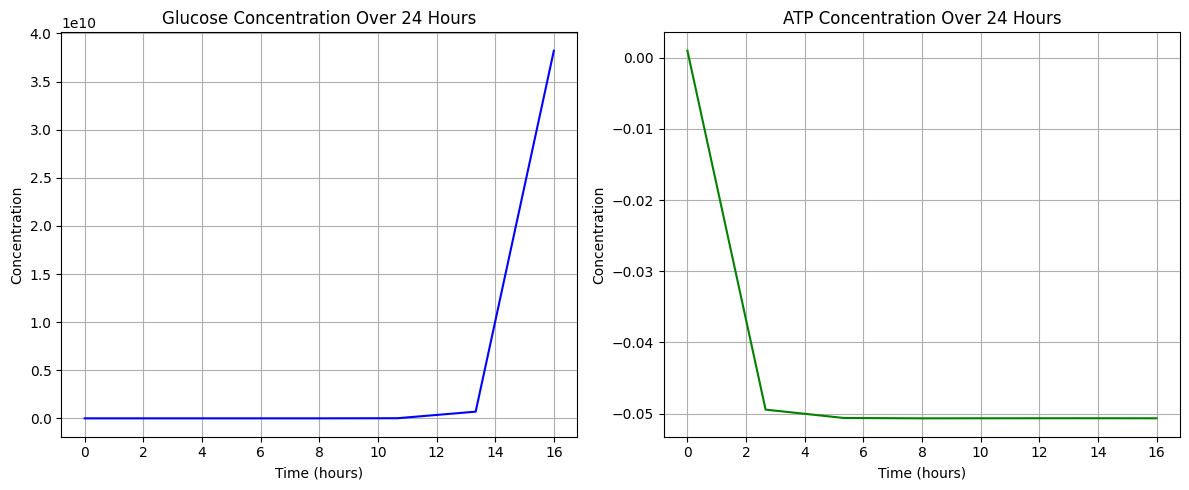

In [26]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Initial conditions for the 17 variables (based on indexing used in model)
# y[3] = glucose, y[16] = ATP
y0 = np.zeros(17)
y0[3] = 1.4 #G/L   
y0[16] = 0.001  # Example initial ATP concentration

# Time span in seconds for 24 hours
t_span = (0, 24)
t_eval = np.linspace(t_span[0], t_span[1], 10)

# Run the simulation
solution = solve_ivp(fun=lambda t, y: skeletalmuscle(t, y, p),
                     t_span=t_span,
                     y0=y0,
                     t_eval=t_eval,
                     method='LSODA')

# Extract glucose and ATP
time_hours = solution.t   # Convert time to hours
glucose = solution.y[3]
atp = solution.y[16]

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(time_hours, glucose, label='Glucose', color='blue')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration')
plt.title('Glucose Concentration Over 24 Hours')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(time_hours, atp, label='ATP', color='green')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration')
plt.title('ATP Concentration Over 24 Hours')
plt.grid(True)

plt.tight_layout()
plt.show()